In [1]:
# profiles / transects
# '../data/profiles/*.csv'

# calculated features
# '../data/results_all.csvf'

In [2]:
%matplotlib inline

import os
import re
import glob
import math
import pandas as pd
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt

In [3]:
PROFILES_FOLDER = f'./mrzezyno_2022_02_sfm/output/profiles/cropped/*.csv'
RESULTS_FILE = './mrzezyno_2022_02_sfm/output/results/shaper_method_2.csv'

In [4]:
def get_distance(ax, ay, bx, by):
    return ((ax - bx)**2 + (ay - by)**2) ** 0.5

def project_points(transect_csv, subpoints):
    subpoints_idx = []
    for subpoint in subpoints:

        dist1 = float('inf')
        dist2 = float('inf')
        for point in transect_csv.loc[:, ['x_geo', 'y_geo', 'no_point']].values:
            d1 = get_distance(point[0], point[1], subpoint[1], subpoint[2])
            d2 = get_distance(point[0], point[1], subpoint[3], subpoint[4])
            if d1 < dist1:
                dist1 = d1
                idx1 = point[2]
            if d2 < dist2:
                dist2 = d2
                idx2 = point[2]                
        
        subpoints_idx.append([min([idx1, idx2]), max([idx1, idx2])])

    return subpoints_idx

In [18]:
def draw_profile_features(title, axlines, features, points, transect, begin_no, end_no, zoom=False, save=False, show=True, link=False):
    
    cut = transect[transect['index_right'] >= 0]

    if len(cut) > 0:
        first_no = cut.iloc[0]['no_point']
        last_no = cut.iloc[-1]['no_point'] + 1
        first_no = first_no if first_no > begin_no else begin_no
        last_no = last_no if last_no < end_no else end_no
 
        x_min = begin_no if not zoom else first_no - 10
        x_max = end_no if not zoom else last_no + 10
            
        plt.xlim((x_min, x_max))
        plt.ylim((min(transect.elevation) - 1, max(transect.elevation) + 10)) 
        plt.gca().set_aspect('equal')
        plt.title(f'{title}  {"[zoomed]" if zoom else ""}')
        plt.xlabel('point no')
        plt.grid(linestyle=':')

        for line in axlines:
            plt.axhline(y = line, color = 'y', linestyle = '--')
            
        if link:
            point1 = [cut.iloc[0]['no_point'], transect.elevation[cut.iloc[0]['no_point']]]
            point2 = [cut.iloc[-1]['no_point'], transect.elevation[cut.iloc[-1]['no_point']]]
            x_values = [point1[0], point2[0]]
            y_values = [point1[1], point2[1]]
            plt.plot(x_values, y_values, 'r', linestyle="dotted")
        
        for f in features:
            y = transect[f][begin_no:end_no].to_numpy()
            plt.plot(np.arange(begin_no, end_no), y, '--')            
            
            y1 = transect[f][first_no:last_no].to_numpy()
            plt.plot(np.arange(first_no, last_no), y1)    
         
            
        def plot_point(name, point, base, color, mark):
            if math.isnan(point):
                return
    
            point = point.astype(int)
            if point < len(y) and point > 0:
                # point
                plt.plot(point, y[point], f'{color}{mark}', label=f'{name}: {point}')

                # line
                l = max(y) / 4
                yy = y[point] + (max((l, 4)) * base/abs(base)) # + label_y
                plt.plot((point, point), (y[point], yy), f'{color}--')

                # label
                plt.annotate(point, (point, yy))

        if len(points) > 0:
#             plot_point('M1_D_high', points['M1_D_high'].iloc[0], base=2, color='r', mark='o')
            plot_point('M2_D_high', points['top'].iloc[0], base=2, color='y', mark='o')
#             plot_point('M1_D_low', points['M1_D_low'].iloc[0], base=2, color='g', mark='o')
            plot_point('M2_D_low', points['bottom'].iloc[0], base=2, color='b', mark='o')

        plt.legend()
            
        if save:
            plt.savefig(f'../data/jpg/{title}.cut{".zoom" if zoom else ""}.jpg', bbox_inches='tight', pad_inches=1, dpi=300)

        if show:
            plt.show()      

        plt.close()

In [19]:
csv_results = pd.read_csv(RESULTS_FILE, encoding='utf-8', sep=',', skipinitialspace=True)
id_list = csv_results.profile_id

In [20]:
transect_files = list(filter(lambda p: int(re.search('\d{1,2}', p)[0]) in id_list, natsorted(glob.glob(PROFILES_FOLDER))))

transects = []
transect_names = []

for name in transect_files:
    transect_names.append(name)
    transects.append(pd.read_csv(name, encoding='utf-8', sep=',', skipinitialspace=True))

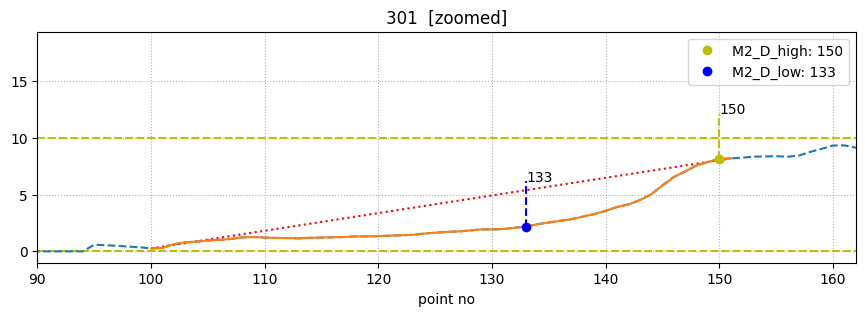

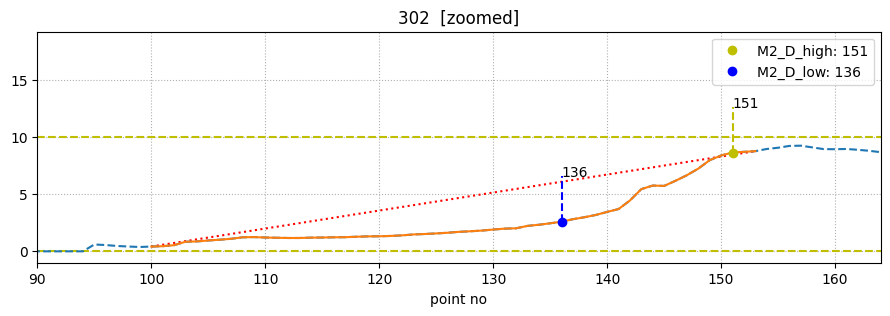

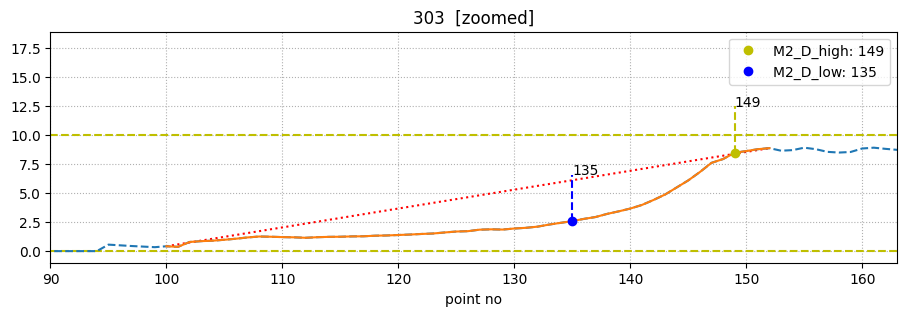

In [21]:
plt.rcParams["figure.figsize"] = (20,3)
    
# for idx in range(len(transects)):
for idx in range(300, 303):
    profile_id = int(re.findall('\d{1,4}', os.path.basename(transect_names[idx]))[0])

    draw_profile_features(
        title=profile_id,
        axlines=[0, 10], # threshold
        features=['elevation'],
        points=csv_results.loc[csv_results['profile_id'] == profile_id],
        transect=transects[idx],
        begin_no=0,
        end_no=len(transects[idx]) - 1,        
        zoom=True,
        save=False,
        show=True,
        link=True
    )